In [1]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd 

import requests, json, glob, random, os, sys, time, copy, scipy

from fastavro import reader, writer, parse_schema, json_writer, schemaless_writer

from utils_sn import read_template_list,read_shift_template,get_filter

In [2]:
sngroup={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                'IaBright':(['1991T','1999ee'],10), 
                'IaFaint':(['1991bg'],15), 
                'Iapec':(['2000cx','2002cx'],5)},
          'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                'IIL':(['1992H'],10),                           # 10
                'IIb':(['1993J','2008ax'],10),                  # 10
                'II87A':(['1987A'],10)},                        # 10
          'IIn':{'IIn':(['2010jl'],45),
                 'IIna':(['1998S'],45), 
                 'IIpec':(['1997cy','2005gj'],10)},
          'Ibc':{'Ib':(['2009jf','2008D'],27), 
                 'Ic':(['1994I','2004aw','2007gr'],68), 
                 'IcBL':(['1998bw'],5)}, 
          'SLSN' : {'SLSN':(['2008es'],100)}}
snlist= []
for ty in sngroup:
    for sty in sngroup[ty]:
        snlist += sngroup[ty][sty][0]


In [3]:
tsn,alltypes = read_template_list()
phobs,magobs = {},{}
lcfolder= os.path.expanduser('~/ongoing_projects/kcor/lc/')
phobs,magobs = {},{}
for sn in snlist:
    phobs[sn],magobs[sn]=read_shift_template( sn,tsn,alltypes)

Reading SN light curve templates


In [4]:
phobs.keys()

dict_keys(['1990N', '1992A', '1994D', '2002bo', '1991T', '1999ee', '1991bg', '2000cx', '2002cx', '1999em', '2004et', '2009bw', '1999br', '1999gi', '2005cs', '1992H', '1993J', '2008ax', '1987A', '2010jl', '1998S', '1997cy', '2005gj', '2009jf', '2008D', '1994I', '2004aw', '2007gr', '1998bw', '2008es'])

In [42]:
from scipy.interpolate import interp1d
sngroup={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                'IaBright':(['1991T','1999ee'],10), 
                'IaFaint':(['1991bg'],15), 
                'Iapec':(['2000cx','2002cx'],5)},
          'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                'IIL':(['1992H'],10),                           # 10
                'IIb':(['1993J','2008ax'],10),                  # 10
                'II87A':(['1987A'],10)},                        # 10
          'IIn':{'IIn':(['2010jl'],45),
                 'IIna':(['1998S'],45), 
                 'IIpec':(['1997cy','2005gj'],10)},
          'Ibc':{'Ib':(['2009jf','2008D'],27), 
                 'Ic':(['1994I','2004aw','2007gr'],68), 
                 'IcBL':(['1998bw'],5)}, 
          'SLSN' : {'SLSN':(['2008es'],100)}}
phase_new=np.arange(-20,100,3)
cols = np.arange(len(phase_new)*3)
data = pd.DataFrame(columns=cols)
for i,ty in enumerate(sngroup.keys()):
    if ty =='Ia':
        continue
    for j,subtype in enumerate(sngroup[ty].keys()):
        for k,sn in enumerate(sngroup[ty][subtype][0]):
            for l, z in enumerate(phobs[sn].keys()):
                F = []
                for t,f in enumerate(phobs[sn][z].keys()):                    
                    snmodel = interp1d(phobs[sn][z][f], magobs[sn][z][f],fill_value="extrapolate")
                    mag_new = snmodel(phase_new)
                    Flux = 10**(-0.4*mag_new)*10**(9)        
                    F.append(Flux)
                F=np.array(F).flatten()
                data.loc[len(data)] = F

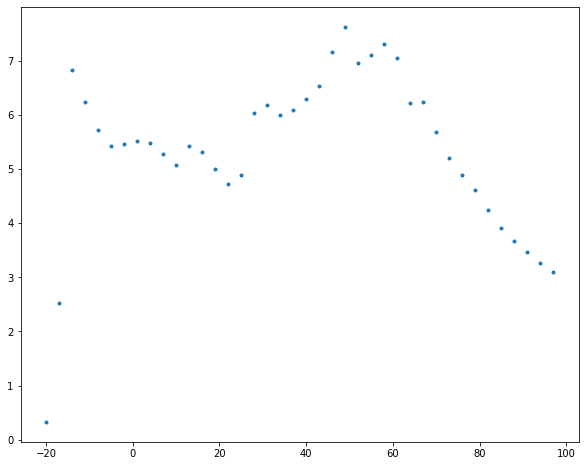

In [722]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(phase_new, Flux, '.')

In [44]:
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal as Normal 
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

In [45]:
class RealNVP_Transform(nn.Module):
    def __init__(self, binary_mask):
        """
        binary mask: boolean array of length LATENT_SIZE; the  binary mask determines which part of the data
        is transformed and which part stays the same
        """
        super().__init__()
        self.size         = len(binary_mask)
        self.mask         =  binary_mask[None,:].float()                  
        self.inverse_mask = (~binary_mask[None,:]).float()
        
        #registering the network parameters
        self.fc1_s        = torch.nn.Linear(self.size,self.size)
        self.fc2_s        = torch.nn.Linear(self.size,self.size)
        self.fc1_b        = torch.nn.Linear(self.size,self.size)
        self.fc2_b        = torch.nn.Linear(self.size,self.size)


    # network for computing s
    def network_s(self,x):
        x = self.fc1_s(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc2_s(x)
        x = torch.clip(x,-5,5)
        x = x*self.inverse_mask
        return x

    # network for computing t
    def network_t(self,x):
        x = self.fc1_b(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc1_b(x)
        x = x*self.inverse_mask
        return x

    # a forward pass (applies the affine trasnsform to one part of the data and leaves the other part immuted)
    def forward(self, u):
        masked_input = u*self.mask
        input        = u*self.inverse_mask
        s            = self.network_s(masked_input)
        t            = self.network_t(masked_input)
        z            = torch.exp(s)*input+t
        log_detJ     = torch.sum(s, axis=-1)
        z            = self.inverse_mask*z+masked_input
        return z, log_detJ

    # inverse of the forward pass
    def inverse(self,z):
        masked_input = z*self.mask
        input        = z*self.inverse_mask
        s            = self.network_s(masked_input)
        t            = self.network_t(masked_input)
        u            = (input-t)/torch.exp(s)
        log_detJ_inv = -torch.sum(s,axis=-1)
        u            = self.inverse_mask*u+masked_input
        return u, log_detJ_inv

# the full RealNVP Model
class FlowModel(nn.Module):
    def __init__(self, layers, dim):
        """
        layers: list of RealNVP_Transform instances; transformation layers
        dim   : int; dimensionality of the input data
        """
        super().__init__()
        self.dim      = dim
        self.layers   = nn.ModuleList(layers)
        self.depth    = len(self.layers)
        self.p_u      = MultivariateNormal(torch.zeros(self.dim), torch.eye(self.dim))

    # foward pass
    def forward(self,u):
        for ii, layer in enumerate(self.layers):
          if ii ==0:
            z, det = self.layers[ii].forward(u)
          else:
            z, det_ = self.layers[ii].forward(z)
            det+=det_
        return z, det

    #inverse pass
    def inverse(self,z):
        for ii in np.arange(self.depth-1,-1,-1):
          if ii ==(self.depth-1):
            u, inv_det = self.layers[ii].inverse(z)
          else:
            u, inv_det_ = self.layers[ii].inverse(u)
            inv_det+=inv_det_
        return u, inv_det

    # computes the log prob, using Eq. (1)
    def log_prob(self,z):
        shape        = z.shape
        z            = z.reshape(-1,self.dim)
        u, inv_det   = self.inverse(z)
        log_prob     = self.p_u.log_prob(u)
        log_prob+=inv_det
        return log_prob.reshape(shape[:-1])

    # sample from p(z) by transforming samples from p(u)
    def rsample(self, N_samples):
        u        = self.p_u.rsample(N_samples)
        z        = self.forward(u)[0]
        return z

In [133]:
INPUT_SIZE      = len(cols)
LATENT_SIZE     = 10
LEARNING_RATE   = 1e-3

In [134]:
class VAEEncoder(nn.Module):

    def __init__(self, seed=853):
        super(VAEEncoder, self).__init__()
        # TASK: change the output size of the encoder network. How many parameters must it return to define q(z|x)?
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,75)
        self.fc2 = nn.Linear(75,LATENT_SIZE*2)

    def forward(self, x):
        # TASK: change the output of the encoder network. Instead of just returning z, it should return z and ...?
        # HINT: Don't forget that the standard deviation/variance must be strictly positive!
        # HINT: You might want to use torch.split(): https://pytorch.org/docs/stable/generated/torch.split.html
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = self.fc2(x)
        mu,std = torch.split(x, LATENT_SIZE,dim=-1)
        std    = torch.exp(std) + 1e-8
        return mu, std

class VAEDecoder(nn.Module):

    def __init__(self, seed=620):
        super(VAEDecoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,75)
        self.fc2 = nn.Linear(75,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

In [135]:
NLAYERS = 8
SIZE    = LATENT_SIZE

# create random masks, we mask half of the data in each layer
if SIZE%2==0:
  mask    = np.append(np.zeros(SIZE//2),np.ones(SIZE//2))
else:
  mask    = np.append(np.zeros(SIZE//2+1),np.ones(SIZE//2))
masks= []
np.random.randint(9303)
for ii in range(NLAYERS):
  np.random.shuffle(mask)
  masks.append(torch.as_tensor(mask).bool())
  print(masks[-1])

#initialize the layers
layers  = [RealNVP_Transform(masks[ii]) for ii in range(NLAYERS)]

tensor([ True, False,  True, False, False, False,  True, False,  True,  True])
tensor([False, False, False, False, False,  True,  True,  True,  True,  True])
tensor([ True, False,  True,  True,  True, False, False, False, False,  True])
tensor([ True,  True, False,  True, False, False,  True, False,  True, False])
tensor([ True,  True, False, False, False, False, False,  True,  True,  True])
tensor([ True, False, False,  True, False,  True, False, False,  True,  True])
tensor([False, False,  True,  True, False, False,  True,  True, False,  True])
tensor([False, False,  True,  True, False,  True,  True, False,  True, False])


In [136]:
class VariationalAutoencoder(nn.Module):
    #TASK: add parameters mentioned in point 1. 
    def __init__(self, sample_size, sigma):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        self.sample_size = sample_size
        self.sigma       = sigma
        #TASK: Use the Normal class to define the prior (a standard normal distribution), p(z)
        self.prior       = Normal(torch.zeros(LATENT_SIZE), torch.ones(LATENT_SIZE))

    def change_sample_size(self,sample_size):
        self.sample_size = sample_size
        return True

    def get_q(self,x):
        #TASK: write a method that computes q(z,x)
        #HINT: use the Normal class we imported above
        mu, std = self.encoder(x)
        self.q = Normal(mu, std)
        return True

    def sample_q(self):
        #TASK: write a method that samples from q
        #HINT: use rsample to apply the reparameterization trick
        z_sample = self.q.rsample(torch.Size([self.sample_size]))
        return z_sample

    def get_avg_log_likelihood(self,recons,x):
        #TASK: Write a method that returns the first term in the ELBO (this method should define the likelihood and evaluate the average log likelihood of the reconstruction)
        #HINT: Pay attention to shapes. The function should return an average log likelihood (a single number) for every data point in the batch.
        #HINT: The output shape of Normal(mu, sigma).log_prob() is a little unintuitive. If mu or sigma are N-dimensional, it returns N results (applies N independent Gaussians). 
        #HINT: You need to average over samples from q to obtain the final result.
        ll    = Normal(x[None,:,:], self.sigma)
        log_p = ll.log_prob(recons)
        log_p = torch.sum(log_p,dim=-1)
        return torch.mean(log_p,dim=0)

    def stochastic_kl_divergence(self,z_sample):
        #TASK: Write a method that computes the kl-divergence between q(z|x) and p(z) 
        #HINT: Pay attention to shape
        return torch.mean(torch.sum(self.q.log_prob(z_sample),dim=-1)-torch.sum(self.prior.log_prob(z_sample),dim=-1), dim=0)

    def forward(self, x):
        #TASK: a forward pass should return the two terms in the ELBO
        #HINT: use all the methods we defined above
        self.get_q(x)
        samples = self.sample_q()
        recons  = self.decoder(samples)
        log_likelihood = self.get_avg_log_likelihood(recons,x)
        kl      = self.stochastic_kl_divergence(samples)
        return log_likelihood, kl

In [147]:
VAE = VariationalAutoencoder(6,sigma=0.5)

optimizer = torch.optim.Adam(VAE.parameters(), lr=LEARNING_RATE)



In [125]:
def negative_ELBO(avg_log_likelihood,kl):

    negative_ELBO = - torch.mean(avg_log_likelihood-kl)

    return negative_ELBO

In [113]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        #TASK: compute the loss from the output of the VAE foward pass  
        log_likelihood, kl = model(X)
        loss = loss_fn(log_likelihood,kl)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    #scheduler.step()
    return losses


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, nllh, kl_ = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            #TASK: in the test loop we want to keep track not only of the ELBO, but also of the two terms that contribute to the ELBO (kl diveregence and loglikelihood)
            log_likelihood, kl = model(X)
            test_loss += loss_fn(log_likelihood,kl).item()
            nllh += -np.mean(log_likelihood.cpu().numpy())
            kl_ += np.mean(kl.cpu().numpy())


    test_loss /= num_batches
    kl_ /= num_batches
    nllh /= num_batches

    print(f" Avg test loss      : {test_loss:>8f}")
    print(f" Avg KL             : {kl_:>8f}")
    print(f" Avg negative log likelihood : {nllh:>8f} \n")

    return test_loss, kl_, nllh

In [53]:
from sklearn.model_selection import train_test_split

train_sn, test_sn = train_test_split(data, test_size=0.4, random_state=1)

In [81]:
class SN(Dataset):

    def __init__(self, data, transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = train_sn
        else:
            self.data = test_sn

        self.data = torch.from_numpy(self.data.values).float().to(torch.device('cpu'))
        self.mean = torch.mean(self.data)
        self.std  = torch.std(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.data[idx]-self.mean)/self.std

        return sample


#initialize datasets
training_data = SN(train_sn,train=True)
test_data     = SN(test_sn, train=False)

In [141]:
BATCHSIZE       = 30
BATCHSIZE_TEST  = 65

In [142]:
train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCHSIZE_TEST, shuffle=True)

In [148]:
EPOCHS = 30
SEED   = 1234

train_loss = []
test_loss  = []
for t in range(EPOCHS):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, VAE, negative_ELBO, optimizer))
    test_loss.append(test_loop(test_dataloader, VAE, negative_ELBO))
print("Done!")

Epoch 1
-------------------------------
loss: 689.767700  [    0/  100]
loss: 10825.610352  [   30/  100]
loss: 9451.433594  [   60/  100]
loss: 236.243652  [   30/  100]
 Avg test loss      : 3412.398987
 Avg KL             : 0.479737
 Avg negative log likelihood : 3411.919586 

Epoch 2
-------------------------------
loss: 565.489929  [    0/  100]
loss: 10411.191406  [   30/  100]
loss: 9009.577148  [   60/  100]
loss: 184.620499  [   30/  100]
 Avg test loss      : 3282.267654
 Avg KL             : 0.804434
 Avg negative log likelihood : 3281.463211 

Epoch 3
-------------------------------
loss: 497.398254  [    0/  100]
loss: 10083.449219  [   30/  100]
loss: 8732.813477  [   60/  100]
loss: 140.940216  [   30/  100]
 Avg test loss      : 3130.054489
 Avg KL             : 1.628725
 Avg negative log likelihood : 3128.425858 

Epoch 4
-------------------------------
loss: 443.074036  [    0/  100]
loss: 9442.591797  [   30/  100]
loss: 8330.190430  [   60/  100]
loss: 107.309219  [

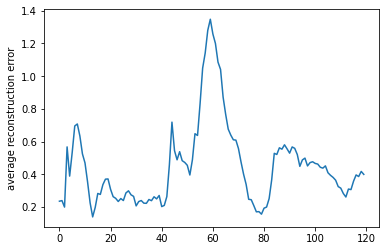

In [144]:
avg_loss  = 0
VAE.eval()
with torch.no_grad():
    for X in test_dataloader:
        pred = VAE.decoder(VAE.encoder(X)[0])
        tmp=np.nanmean((pred.cpu().numpy()-X.cpu().numpy())**2,axis=0)/(len(test_data)//BATCHSIZE_TEST)
        avg_loss+= tmp
plt.figure()
plt.plot(np.sqrt(avg_loss))
plt.ylabel('average reconstruction error')
#plt.xlabel('wavelength [Ångströms]')
plt.show()

In [74]:
import seaborn as sns
import pandas as pd

VAE.eval()
with torch.no_grad():
    for ii, X in enumerate(test_dataloader):
        VAE.get_q(X)
        prior_sample = VAE.prior.sample([BATCHSIZE_TEST])
        sample       = VAE.sample_q().cpu().numpy()[0:1].swapaxes(0,1)
        if ii==0:
          samples       = sample
          prior_samples = prior_sample
        else:
          samples       = np.vstack([samples, sample])
          prior_samples = np.vstack([prior_samples, prior_sample])

samples       = np.reshape(samples,[-1, LATENT_SIZE])
prior_samples = np.reshape(prior_samples,[-1, LATENT_SIZE])

print(samples.shape)
print(prior_samples.shape)

data1    = pd.DataFrame()
data2    = pd.DataFrame()

for ii in range(LATENT_SIZE):
  data1['dim_%d'%ii] = samples[:,ii]
data1['source'] = 'posterior'

for ii in range(LATENT_SIZE):
  data2['dim_%d'%ii] = prior_samples[:,ii]
data2['source'] = 'prior'

data = pd.concat([data1,data2]).reset_index(drop=True)

(68, 10)
(130, 10)


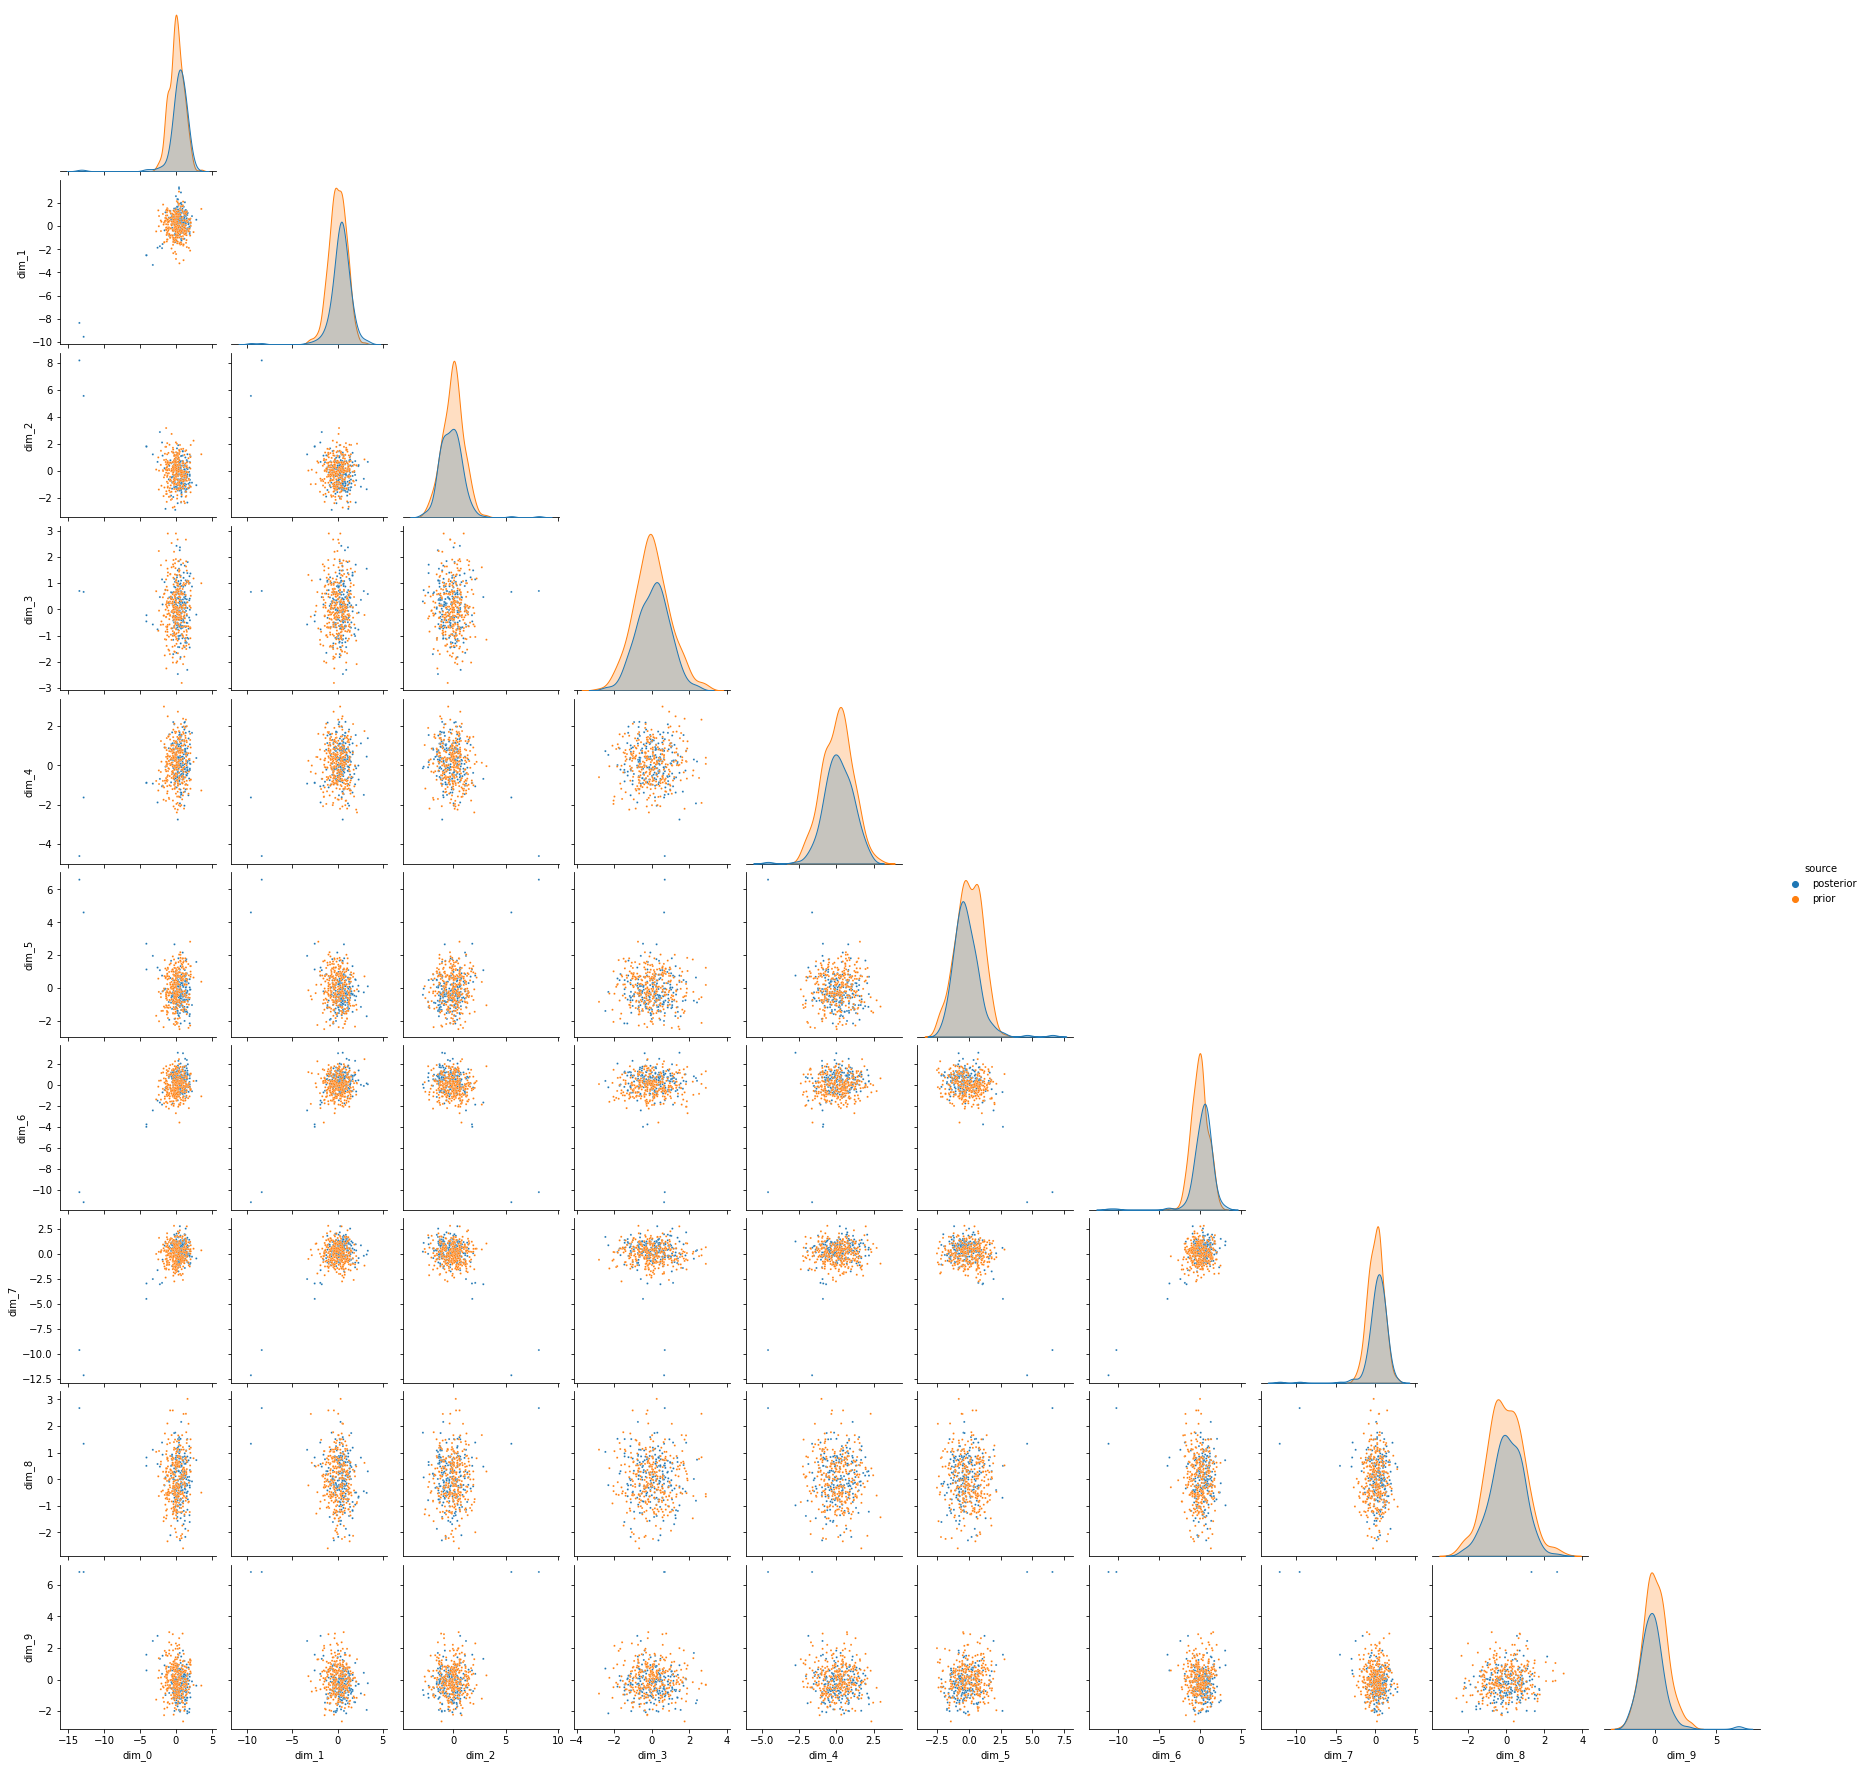

In [22]:
sns.pairplot(data,corner=True,kind='scatter', hue='source', plot_kws={'s':4})
plt.show()

In [75]:
VAE.eval()
with torch.no_grad():
  samples = VAE.prior.sample([16])
  data_samples = VAE.decoder(samples)



In [76]:
data_samples[0]

tensor([-0.2420, -0.1360, -0.2617, -0.0792,  0.4537,  0.1994,  0.1009,  0.3650,
         0.3701,  0.2051,  0.2323,  0.0903,  0.3244,  0.2939,  0.3186,  0.3950,
         0.1691,  0.1438,  0.1218,  0.1279,  0.0118, -0.0903, -0.0114, -0.0289,
        -0.0259, -0.0371, -0.1658,  0.0289, -0.1023,  0.2327, -0.0507, -0.1463,
        -0.1397, -0.0175,  0.0093, -0.1702, -0.0539, -0.1050, -0.3623, -0.1770,
        -0.0169, -0.0778, -0.1417,  0.0160, -0.0527,  0.3784,  0.4693,  0.2993,
         0.4325,  0.1841,  0.4735,  0.3477,  0.5190,  0.1192,  0.3322,  0.2303,
         0.1865,  0.0776,  0.0682,  0.1037,  0.1143, -0.1018,  0.0538,  0.0270,
         0.1051,  0.0803,  0.1283, -0.0842,  0.0500, -0.0765, -0.0610,  0.0081,
        -0.0864, -0.0560, -0.1838, -0.2227, -0.2269, -0.3889, -0.3957, -0.1726,
        -0.2424, -0.0725,  0.0308, -0.1719, -0.0292,  0.0704,  0.2665,  0.3265,
         0.4598,  0.3609,  0.3003,  0.0744,  0.2877,  0.2966,  0.2662, -0.0662,
         0.1001,  0.4475,  0.2032,  0.26

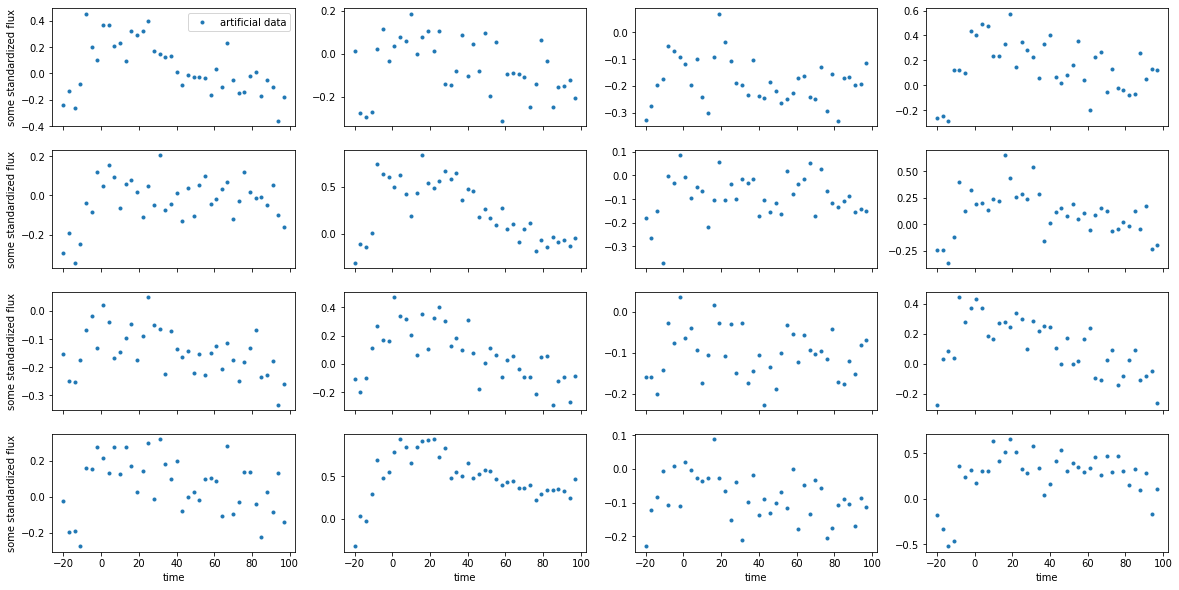

In [77]:
# This is the mapping from pixel to the de-redshifted (rest) wavelength
phase_new=np.arange(-20,100,3)
#phase_new.extend([0,0.2,1])
fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
    #filt = np.where()
    ax[ii].plot(phase_new,data_samples[ii][0:len(phase_new)], '.',label='artificial data')
    if ii in np.arange(12,16):
        ax[ii].set_xlabel('time')
    if ii in [0,4,8,12]:
        ax[ii].set_ylabel('some standardized flux')
    if ii==0:
        ax[ii].legend()
plt.show()